# Example

Here, we apply the inversion algorithm using the $Q(E_\mathrm{SF,pk})$ spectroscopy curve from figure 2b and the waveform taken at 70% of $E_\mathrm{SF,pk}^\mathrm{max}$ from figure 2g. In a second step, we confirm that the waveform is genuine by simulating the current pulse that it induces in the junction and the THz-CC waveform measurment at $E_\mathrm{SF,pk}=70\%$.

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt

'''Import the python file that has all function required for applying the algorithm to data'''
import thzsts as f

## 1. Importing and plotting the input data
We import a test waveform and a sprectroscopy curve into numpy arrays. The waveform is normalized to the absolute highest peak and the $Q(E_\mathrm{SF,pk})$ is in units of electrons per THz pulse with the x-axis being in percentage relative to maximum field strength. The field axis can be converted to voltage by performing the voltage calibration described in the paper (see figure 2e and f).

In [2]:
# import normalized waveform data
wf = np.loadtxt(r"example_data/wf_data.txt").T

# import Q_Thz vs electric field (QE) spectroscopy curve where x-axis is percentage of maximum field strength
qe = np.loadtxt(r"example_data/qe_data.txt").T

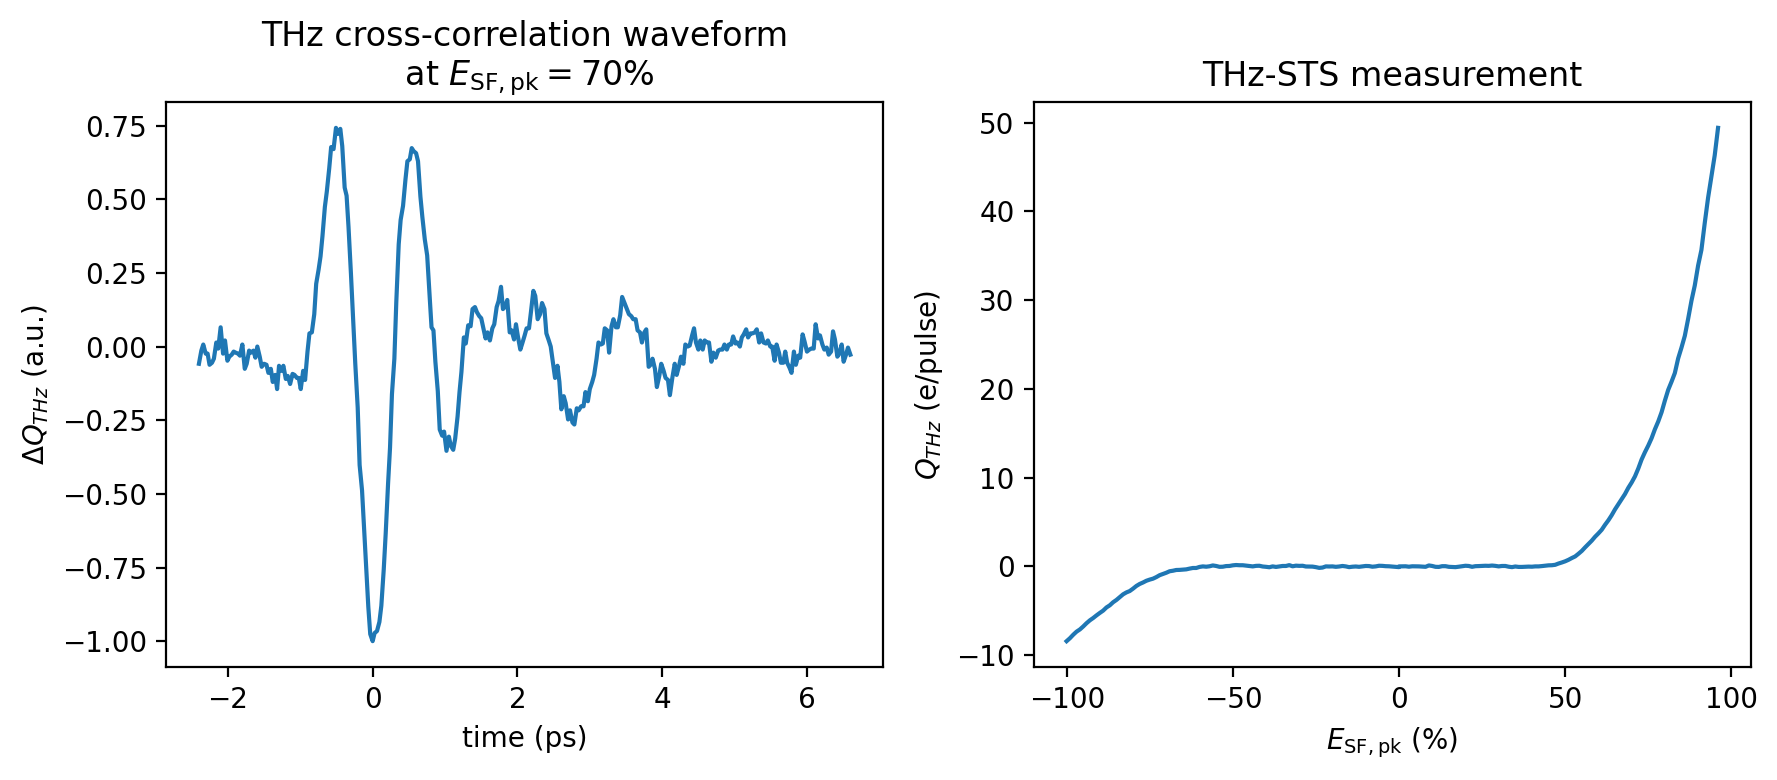

In [3]:
fig, axs = plt.subplots(1,2, dpi=200, figsize=(9,4))

# plot waveform data
axs[0].plot(wf[0], wf[1])
axs[0].set_xlabel("time (ps)")
axs[0].set_ylabel(r"$\Delta Q_{THz}$ (a.u.)")
axs[0].set_title("THz cross-correlation waveform\n at $E_\mathrm{SF, pk}=70\%$")

# plot spectroscopy data
axs[1].plot(qe[0], qe[1])
axs[1].set_xlabel(r"$E_\mathrm{SF, pk}$ (%)")
axs[1].set_ylabel(r"$Q_{THz}$ (e/pulse)")
axs[1].set_title("THz-STS measurement")

fig.tight_layout()

## 2. Applying the Inversion algorithm and simulating the spectroscopy and THz-CC measurement
### 2.1 Determining a good polynomial order p for the QE curve fit

We use shuffle split cross validation to train our fit model and test it. By plotting the behaviour of the error between the model and the train and test data, we can determine the region of good fit between under- and overfitting.

Below, we set a range for polynomial orders that we would like to try out. The number of splits determines how long it takes to compute the MSE curves. 

We also select the python function used to fit our data. In the paper we use skikit learn's linear regression model in combination with 'PolynomialFeatures', another option is scipy's 'curvefit' function.

In [61]:
"""Inversion Parameters"""
poly_order = np.arange(4, 21, 1) # range of polynomial orders to perform fit
splits = 1000 # number of times the data sample is divided into a test and a train sample randomly
train_test_ratio = 0.2 # how the data gets divided into test and train for each split
seed = 333 # if set to a number the result is the same every time
method = "linreg" # select the function used to perform the fit, 'linreg' or 'curvefit'

We can now loop through the polynomial order list. We plot the train and test mean squared error (MSE) against the polynomial order and the fit curve together with the data. Plotting under and over fitting  models, let's us see how they fail at representing the data and for the latter case develop oscillations.

Note that the waveform is not yet used in this step.

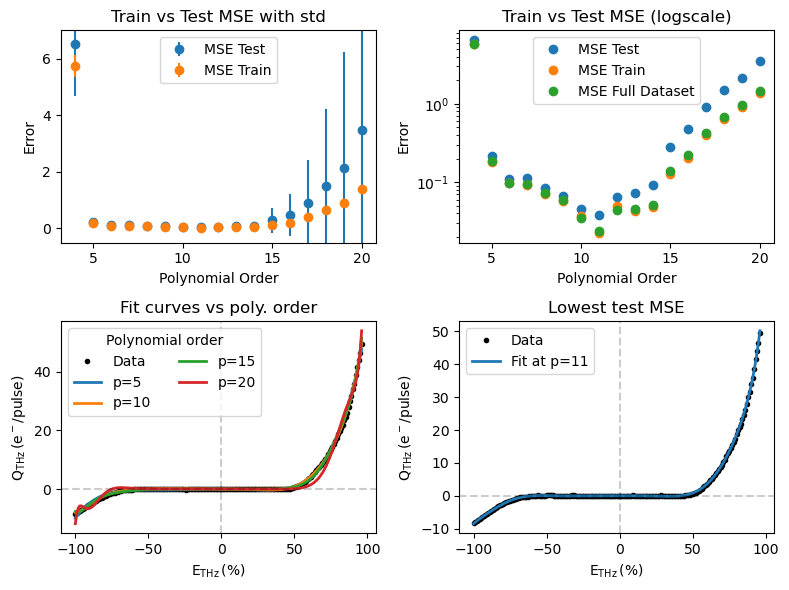

In [63]:
# set up a new figure for each QE and test-train-ratio combination
fig, axs = plt.subplots(2,2, figsize=(8,6)) 

# Arrays to collect Goodness of Fit data
mse_qe_fit = np.empty(len(poly_order))   # Root mean squared error for fitting to QE curve
test_loss_avg = np.empty(len(poly_order)) # mean error for test data and trained fit model for all splits
test_loss_std = np.empty(len(poly_order)) # standard deviation of the above
train_loss_avg = np.empty(len(poly_order)) # mean error for train data and trained fit model for all splits
train_loss_std = np.empty(len(poly_order)) # standard deviation of the above
fit_qe_list = []

axs[1,0].plot(qe[0], qe[1], "k.", linewidth=2, label="Data")

# loop through the polynomial orders
for idx, p in enumerate(poly_order):
    # perform fit, note that the actual fitting part of the inersion algorithm does not require a waveform
    (Cn, test_loss_avg[idx], test_loss_std[idx], train_loss_avg[idx], train_loss_std[idx], 
    fit_qe, mse_qe_fit[idx]) = (f.shuffle_splits_fit(qe=qe,p_order=p, splits=splits, train_test_ratio=train_test_ratio, 
                         rand_seed=seed, method=method)   )
    
    fit_qe_list.append(fit_qe)
    
    # plot every 5th fit QE curve
    if p%5 == 0:
        axs[1,0].plot(fit_qe[0], fit_qe[1], label="p="+str(p), linewidth=2)

# plot the averaged MSE vs polynomial terms with the standard deviation as errorbars
axs[0,0].errorbar(poly_order, test_loss_avg, test_loss_std, fmt ='o', label=r"MSE Test")
axs[0,0].errorbar(poly_order, train_loss_avg, train_loss_std, fmt ='o', label=r"MSE Train")
axs[0,0].set_xlabel("Polynomial Order")
axs[0,0].set_ylabel("Error")
axs[0,0].set_ylim((-0.5, 7))
axs[0,0].set_title("Train vs Test MSE with std")
axs[0,0].legend(loc="upper center")

# plot the averaged MSE for the training data, test data and  the full dataset vs polynomial terms on logscale
axs[0,1].semilogy(poly_order, test_loss_avg, 'o', label=r"MSE Test")
axs[0,1].semilogy(poly_order, train_loss_avg, 'o', label=r"MSE Train")
axs[0,1].semilogy(poly_order, mse_qe_fit, 'o', label=r"MSE Full Dataset")
axs[0,1].set_xlabel("Polynomial Order")
axs[0,1].set_ylabel("Error")
axs[0,1].set_title("Train vs Test MSE (logscale)")
axs[0,1].legend()

# finish up the plot of the different order QE fit curves
axs[1,0].set_xlabel(r"$\mathrm{E}_\mathrm{THz}\,\mathrm{(\%)}$")
axs[1,0].set_ylabel(r"$\mathrm{Q}_\mathrm{THz}\,(\mathrm{e}^-/\mathrm{pulse})$")
axs[1,0].axhline(y = 0, color="k", linestyle = '--', alpha=0.2)
axs[1,0].axvline(x = 0, color="k", linestyle = '--', alpha=0.2)   
axs[1,0].legend(title="Polynomial order", ncol=2)
axs[1,0].set_title("Fit curves vs poly. order")

# plot the best order QE fit together with the data
axs[1,1].plot(qe[0], qe[1], "k.", label="Data")
axs[1,1].plot(fit_qe_list[np.argmin(test_loss_avg)][0], fit_qe_list[np.argmin(test_loss_avg)][1], 
              label="Fit at p=" + str(poly_order[np.argmin(test_loss_avg)]), linewidth=2)
axs[1,1].set_xlabel(r"$\mathrm{E}_\mathrm{THz}\,\mathrm{(\%)}$")
axs[1,1].set_ylabel(r"$\mathrm{Q}_\mathrm{THz}\,(\mathrm{e}^-/\mathrm{pulse})$")
axs[1,1].axhline(y = 0, color="k", linestyle = '--', alpha=0.2)
axs[1,1].axvline(x = 0, color="k", linestyle = '--', alpha=0.2)   
axs[1,1].legend()
axs[1,1].set_title("Lowest test MSE")

fig.tight_layout()

From the first plot of the mean squared error including the standard deviation we can tell that polynomial orders with their highest term at 15 and overfit the data because the standard deviation of the test MSE goes up significantly. In the second plot we can investigate the region between p=5 and p=15 better by plotting it on logarithmic scale. We find the MSE decreases until it reaches p=11 and then increases again. We note that scikit learn and scipy curvefit handle large fit coefficients differently which can lead to different ranges of good polynomial order when comparing the two. We find that 'curvefit' performs better for high order polynomials but is more prone to introduce unphysical oscillations to the extracted dI/dV curve compared to scikit learn's 'linreg'.

## 2.2 Performing the inversion algorithm and simulations

We select p=11 as the polynomial order that best describes the underlying model. The input waveform has to be normalized such that that its absolute maximum peak is 1. To perform the inversion algorithm we set the field of the input waveform such that we can simulate the THz-CC measurement at the value the waveform was measured at and compare their shapes. For the simulation we set the weak (probe) field to 3% of the maximum (100%) strong field pulse.

In [64]:
"""Set waveform field strength and make sure max peak for waveform is at +1."""
field_axis_cc = 70 # the waveform used here was taken at 70% field strength
wf_inversion = np.vstack((wf[0], wf[1]*(-1)))

"""Set parameters for the inversion and THz-CC simulation"""
probe_size = 0.03 # this was measured in our setup, see extended data
p = 11 # determined in the previus section

"""Set same parameters as above to be consisten twith the chosen polynomial order."""
splits = 1000 # number of times the data sample is divided into a test and a train sample randomly
train_test_ratio = 0.2 # how the data gets divided into test and train for each split
seed = 333 # if set to a number the result is the same every time
method = "linreg" # select the function used to perform the fit, 'linreg' or 'curvefit'

Perform the inversion to extract the I(V) and dI/dV curves as well as the simulated QE curve and curent pulse induced by the waveform. The simulated Q(E) curves serves as a check tha tthe previous steps were performed correctly. It should closely match the Q(E) measurement.

In [65]:
# perform inversion
ext_iv, ext_didv, fit_qe, sim_qe, sim_it = f.inversion_algorithm_splits(
    wf_inversion, qe, p, splits, train_test_ratio, rand_seed=seed, mse_metrics=False, method="linreg")

# simulate THz-CC input waveform
thz_cc_sim_input = f.simulate_Thz_CC(wf=wf_inversion, efield=field_axis_cc, ext_iv=ext_iv, 
                                     probe_size=probe_size, t_min=min(wf_inversion[0]), 
                                     t_max=max(wf_inversion[0]), delay_pts=len(wf[0]))

### 2.3 Plot the results and determine whether the input waveform is genuine

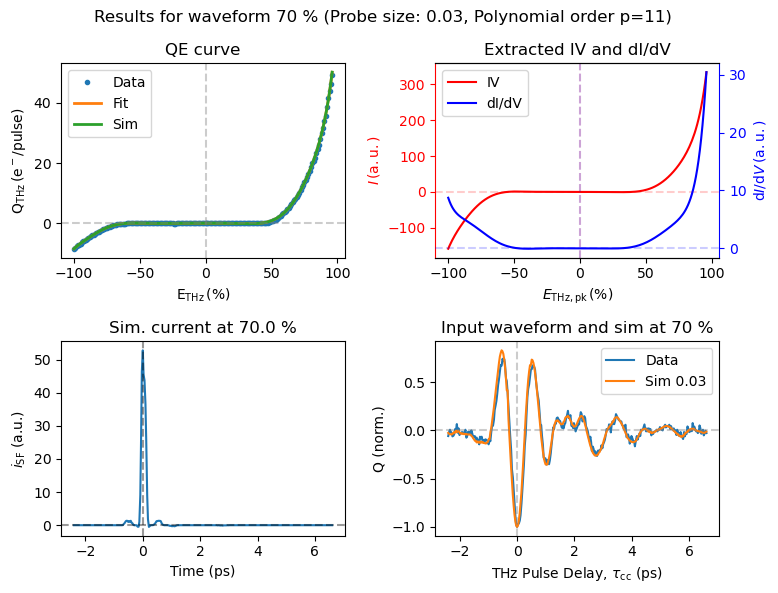

In [77]:
# set up figure for each waveform with subplots of different sizes
fig, axs = plt.subplot_mosaic([['a', 'b'], ['c','d']], figsize=(8,6))

# Plot the QE data and the fit and simulated data
axs["a"].plot(qe[0], qe[1],".", label="Data", linewidth=2)
axs["a"].plot(fit_qe[0], fit_qe[1], label="Fit", linewidth=2 )
axs["a"].plot(sim_qe[0], sim_qe[1], label="Sim", linewidth=2)
axs["a"].set_xlabel(r"$\mathrm{E}_\mathrm{THz}\,\mathrm{(\%)}$")
axs["a"].set_ylabel(r"$\mathrm{Q}_\mathrm{THz}\,(\mathrm{e}^-/\mathrm{pulse})$")
axs["a"].legend()
axs["a"].set_title("QE curve")
axs["a"].axhline(y = 0, color="grey", linestyle = '--', alpha=0.4)
axs["a"].axvline(x = 0, color="grey", linestyle = '--', alpha=0.4)

# Plot the I(V) and dI/dV
ln1 = axs["b"].plot(ext_iv[0], ext_iv[1], "r", scalex=True, scaley=True, 
               label=(r"IV"))
axs["b"].set_xlabel(r"$E_\mathrm{THz,pk}\,(\mathrm{\%})$")
axs["b"].set_ylabel("$I\,(\mathrm{a.u.})$")  #"(V)\,(\propto\mathrm{pA})$")
axs["b"].spines["right"].set_visible(False)
axs["b"].yaxis.label.set_color(ln1[0].get_color())
axs["b"].spines["left"].set_edgecolor(ln1[0].get_color())
axs["b"].tick_params(axis="y", colors=ln1[0].get_color())
axs["b"].axhline(y = 0, color=ln1[0].get_color(), linestyle = '--', alpha=0.2)
axs["b"].axvline(x = 0, color=ln1[0].get_color(), linestyle = '--', alpha=0.2)
axs["b"].set_title("Extracted IV and dI/dV")
axs_twin = axs["b"].twinx()
ln2 = axs_twin.plot(ext_didv[0], ext_didv[1], "b", scalex=True, scaley=True, label="dI/dV")
axs_twin.set_ylabel("$\mathrm{d}I/\mathrm{d}V\,(\mathrm{a.u.})$")
axs_twin.yaxis.label.set_color(ln2[0].get_color())
axs_twin.spines["right"].set_edgecolor(ln2[0].get_color())
axs_twin.spines["left"].set_visible(False)
axs_twin.tick_params(axis="y", colors=ln2[0].get_color())
axs_twin.axhline(y = 0, color=ln2[0].get_color(), linestyle = '--', alpha=0.2)
axs_twin.axvline(x = 0, color=ln2[0].get_color(), linestyle = '--', alpha=0.2)
lns = ln1+ln2
labs = [l.get_label() for l in lns]
axs["b"].legend(lns, labs, loc="upper left")

# Find the index in the QE curve that is closest to the field of the input waveform
it_idx = np.argmin(np.abs(np.subtract(qe[0], field_axis_cc)))
axs["c"].plot(wf[0], sim_it[it_idx])
axs["c"].set_title("Sim. current at " + str(np.round(qe[0, it_idx],2)) + " %")
axs["c"].set_ylabel(r"$i_\mathrm{SF}$ (a.u.)")
axs["c"].set_xlabel("Time (ps)")
axs["c"].axhline(y = 0, color="k", linestyle = '--', alpha=0.4)
axs["c"].axvline(x = 0, color="k", linestyle = '--', alpha=0.4)


# Plotting the input waveform and its THz-CC simulation
axs["d"].plot(wf[0], wf[1]/np.abs(np.min(wf[1])),label="Data")
axs["d"].plot(thz_cc_sim_input[0], thz_cc_sim_input[1]/np.abs(np.min(thz_cc_sim_input[1])), label=("Sim " + str(probe_size)))
axs["d"].set_title("Input waveform and sim at " + str(field_axis_cc) + " %" )
axs["d"].set_xlabel(r"THz Pulse Delay, $\tau_\mathrm{cc}$ (ps)")
axs["d"].set_ylabel("Q (norm.)")
axs["d"].axhline(y = 0, color="grey", linestyle = '--', alpha=0.4)
axs["d"].axvline(x = 0, color="grey", linestyle = '--', alpha=0.4)
axs["d"].legend()

fig.suptitle("Results for waveform "+ str(field_axis_cc) + " % (Probe size: " + str(probe_size)
            + ", Polynomial order p=" + str(p) + ")")

fig.tight_layout()

From the upper left plot we can confirm that the fit matches the data and that the extracted I(V) curve yields a curve that closely resembles the Q(E) data when we simulate it using the input waveform.

The upper right figure shows the extracted I(V) and dI/dV curve (actually I(E) and dI/dE but all proportional since we assume $E \propto V$). We use arbitrary units because the algorithm cannot extract the linear term in the I(V) curve (constant offset in the dI/dV). If we apply the input waveform scaled to 70% peak to the extracted I(V) curve we get the current pulse shown at the bottom left. It is unipolor and single cycle as is required to measure a correct waveform. 

We simulate the THz-CC waveform measurement by using the strong field pulse scaled to 70% and the weak field pulse scaled to 3% which is then scanned across the strong field waveform. The simulation closely mateches the input waveform.

The two bottom plots lead us to conclude that we have measured the true waveform locally in the tip-sample junction.